# **Project 2: Sentiment Analysis Reloaded**

Clara Paola Aguilar Casillas

Daniela De La Torre Gallo

Samantha Sánchez Tinoco

Import the necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import re
import string

# NLP and ML
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt


## Part 1: Baseline setup

In [ ]:
# Import dataset
data = pd.read_csv("./Data/auspol2019.csv")
data.head()

,created_at,id,full_text,retweet_count,favorite_count,user_id,user_name,user_screen_name,user_description,user_location,user_created_at
0,2019-05-20 09:13:44,1130401208756187136,After the climate election: shellshocked green...,0.0,0.0,9.248486e+07,PIPELINEPETE,jocksjig,Retired Tradesman and Progressive Anti Conserv...,"Brisbane, Queensland",2009-11-25 09:19:45
1,2019-05-20 09:13:43,1130401205367140357,@narendramodi @smritiirani Coverage of indian ...,0.0,0.0,7.756474e+08,Narinder Parmar,nparmar1957,"Life coach & trainer, Motivational speaker, Ma...","Wollongong, NSW, AUSTRALIA",2012-08-23 10:20:40
2,2019-05-20 09:13:33,1130401162782371841,@workmanalice Do you know if Facebook is relea...,0.0,0.0,5.687300e+04,Peter Wells,peterwells,Writes for @theage and @smh on technology and ...,Melbourne,2006-12-11 07:38:06
3,2019-05-20 09:13:29,1130401143551434753,@vanbadham We all understand we have a compuls...,0.0,0.0,9.081660e+17,The Realist,therealist822,"Calls it as I see it. Anti PC, SJW and VS. If ...",NaN,2017-09-14 03:10:30
4,2019-05-20 09:13:23,1130401118666809345,"Shares were mixed in Asia, with India and Aust...",0.0,0.0,5.260074e+08,Inquirer Business,InquirerBiz,The official Twitter account of the Inquirer G...,Philippines,2012-03-16 03:51:59


In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84977 entries, 0 to 84976
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   created_at        84977 non-null  object 
 1   id                84977 non-null  object 
 2   full_text         84976 non-null  object 
 3   retweet_count     84972 non-null  float64
 4   favorite_count    84972 non-null  float64
 5   user_id           84972 non-null  float64
 6   user_name         84964 non-null  object 
 7   user_screen_name  84972 non-null  object 
 8   user_description  77122 non-null  object 
 9   user_location     67354 non-null  object 
 10  user_created_at   84968 non-null  object 
dtypes: float64(3), object(8)
memory usage: 7.1+ MB


Limpieza del texto de los tweets

In [ ]:
df_clean = data.copy()

# Use the column of the original text
TEXT_COL = "text" 

df_clean["clean_text"] = (
    df_clean["full_text"]
        .astype(str)
        .str.lower()
        .str.replace(r"http\S+", "", regex=True)        # remove URLs
        .str.replace(r"@\w+", "", regex=True)           # @mencions
        .str.replace(r"#\w+", "", regex=True)           # hashtags
        .str.replace(r"[^a-z\s]", "", regex=True)       # non alphabetic characters
        .str.replace(r"\s+", " ", regex=True)           # multiple spaces
        .str.strip()
)

df_clean.head()


,created_at,id,full_text,retweet_count,favorite_count,user_id,user_name,user_screen_name,user_description,user_location,user_created_at,clean_text
0,2019-05-20 09:13:44,1130401208756187136,After the climate election: shellshocked green...,0.0,0.0,9.248486e+07,PIPELINEPETE,jocksjig,Retired Tradesman and Progressive Anti Conserv...,"Brisbane, Queensland",2009-11-25 09:19:45,after the climate election shellshocked green ...
1,2019-05-20 09:13:43,1130401205367140357,@narendramodi @smritiirani Coverage of indian ...,0.0,0.0,7.756474e+08,Narinder Parmar,nparmar1957,"Life coach & trainer, Motivational speaker, Ma...","Wollongong, NSW, AUSTRALIA",2012-08-23 10:20:40,coverage of indian election on sbs tv channel ...
2,2019-05-20 09:13:33,1130401162782371841,@workmanalice Do you know if Facebook is relea...,0.0,0.0,5.687300e+04,Peter Wells,peterwells,Writes for @theage and @smh on technology and ...,Melbourne,2006-12-11 07:38:06,do you know if facebook is releasing an electi...
3,2019-05-20 09:13:29,1130401143551434753,@vanbadham We all understand we have a compuls...,0.0,0.0,9.081660e+17,The Realist,therealist822,"Calls it as I see it. Anti PC, SJW and VS. If ...",NaN,2017-09-14 03:10:30,we all understand we have a compulsory prefere...
4,2019-05-20 09:13:23,1130401118666809345,"Shares were mixed in Asia, with India and Aust...",0.0,0.0,5.260074e+08,Inquirer Business,InquirerBiz,The official Twitter account of the Inquirer G...,Philippines,2012-03-16 03:51:59,shares were mixed in asia with india and austr...


Generate labels

In [25]:
CANDIDATES = {
    0: ["morrison", "scomo", "liberal"],
    1: ["shorten", "labor", "alp"]
}

Assign labels per party

In [ ]:
# Import sentiment analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Create an object of the analyzer
analyzer = SentimentIntensityAnalyzer()

# Define the function that will label sentiment towards candidates
def label_by_entity_sentiment(text, window_chars=50):
    """
    Retorna una etiqueta (label) según el sentimiento hacia un candidato:
    0 → Pro-Morrison
    1 → Pro-Shorten
    None → Neutral o sin información suficiente
    """
    
    # Convert the text to minuscule to search keywords without errors
    text_l = text.lower()

    # Get the dictionary of candidates with their keywords
    for label, keywords in CANDIDATES.items():

        # Go through each keyword (name or related term to the candidate)
        for kw in keywords:

            # If the keyword is present in the text
            if kw in text_l:

                # Find the index where the keyword appears
                idx = text_l.find(kw)

                # Calculate a window of characters before and after the name
                # This is useful to analyze only the immediate context of the candidate
                start = max(0, idx - window_chars) 
                end = min(len(text_l), idx + len(kw) + window_chars) 

                # Extract the text fragment (the context window)
                window = text_l[start:end]

                # Calculate the sentiment score of the fragment
                # 'coumpound' gives a value between -1 (negative) and +1 (positive)
                score = analyzer.polarity_scores(window)["compound"]

                # If the sentiment is positive or greater than 0.05 → in favor of the candidate
                if score >= 0.05:
                    return label      # Returns 0 for pro-Morrison, 1 for pro-Shorten

                # If the sentiment is negative or less than -0.05 → against the candidate
                elif score <= -0.05:
                    return 1 - label  # Returns 1 for anti-Morrison (pro-Shorten), 0 for anti-Shorten (pro-Morrison)

                # If the sentiment is neutral (0.05 > score > -0.05)
                else:
                    return None      

    # If no candidate is mentioned, also return None
    return None


In [ ]:
# Apply the function 'label_by_entity_sentiment' to each text in the DataFrame
# 'df_clean["clean_text"] is the column that contains the cleaned tweets (without noise, mentions, etc.)

df_clean["stance"] = df_clean["clean_text"].apply(label_by_entity_sentiment)

df_clean.head()


,created_at,id,full_text,retweet_count,favorite_count,user_id,user_name,user_screen_name,user_description,user_location,user_created_at,clean_text,stance
0,2019-05-20 09:13:44,1130401208756187136,After the climate election: shellshocked green...,0.0,0.0,9.248486e+07,PIPELINEPETE,jocksjig,Retired Tradesman and Progressive Anti Conserv...,"Brisbane, Queensland",2009-11-25 09:19:45,after the climate election shellshocked green ...,NaN
1,2019-05-20 09:13:43,1130401205367140357,@narendramodi @smritiirani Coverage of indian ...,0.0,0.0,7.756474e+08,Narinder Parmar,nparmar1957,"Life coach & trainer, Motivational speaker, Ma...","Wollongong, NSW, AUSTRALIA",2012-08-23 10:20:40,coverage of indian election on sbs tv channel ...,NaN
2,2019-05-20 09:13:33,1130401162782371841,@workmanalice Do you know if Facebook is relea...,0.0,0.0,5.687300e+04,Peter Wells,peterwells,Writes for @theage and @smh on technology and ...,Melbourne,2006-12-11 07:38:06,do you know if facebook is releasing an electi...,NaN
3,2019-05-20 09:13:29,1130401143551434753,@vanbadham We all understand we have a compuls...,0.0,0.0,9.081660e+17,The Realist,therealist822,"Calls it as I see it. Anti PC, SJW and VS. If ...",NaN,2017-09-14 03:10:30,we all understand we have a compulsory prefere...,NaN
4,2019-05-20 09:13:23,1130401118666809345,"Shares were mixed in Asia, with India and Aust...",0.0,0.0,5.260074e+08,Inquirer Business,InquirerBiz,The official Twitter account of the Inquirer G...,Philippines,2012-03-16 03:51:59,shares were mixed in asia with india and austr...,NaN


Filter tweets with no clear stance

In [ ]:
# Filter the DataFrame to keep only rows where 'stance' is not null (None)
df_final = df_clean[df_clean["stance"].notnull()].copy()

# Convert the 'stance' column to integer type (int)
df_final["stance"] = df_final["stance"].astype(int)

# Print how many tweets remain after filtering
print("Total final después de filtrar:", len(df_final))

# Count how many tweets there are for each label (0 = pro-Morrison, 1 = pro-Shorten)
df_final["stance"].value_counts()

Total final después de filtrar: 12805


,count
stance,
0,7335
1,5470


### Train test split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_final["clean_text"],   
    df_final["stance"],       
    test_size=0.2,            #  20% of the data will be reserved for testing
    random_state=42,         
    stratify=df_final["stance"]  
)

### TF-IDF Vectorizer

In [ ]:
# Import the vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Create an instance of the TF-IDF vectorizer with certain parameters
tfidf = TfidfVectorizer(
    lowercase=True,    # Automatically converts all text to lowercase
    ngram_range=(1,2), #  Considers unigrams (single words) and bigrams (pairs of words)
    max_features=30000 #  Limits the maximum number of features to 30,000 (reduces size and noise)
)

# Adjust the vectorizer with the training texts and transform to a numerical matrix
X_train_vec = tfidf.fit_transform(X_train)
#  'fit_transform' learns the vocabulary and computes the TF-IDF weights for each word in the training set

# Use the same vocabulary learned to transform the texts of the test set
X_test_vec  = tfidf.transform(X_test)
# 'transform' only applies the transformation without refitting (maintains consistency between train and test)

### Regresión logística

In [ ]:
# Create the classifier
clf = LogisticRegression(
    max_iter=2000,  
    n_jobs=-1       #  Uses all the available CPU cores to speed up training
)

# Train the model with the vectorized data (TF-IDF) and their corresponding labels
clf.fit(X_train_vec, y_train)

# Use the model already trained to predict the stances of the tweets in the test set
pred = clf.predict(X_test_vec)
# This generates an array with the predictions: [0, 1, 1, 0, ...]


In [ ]:
# Calculate and print the accuracy of the model
print("Accuracy:", accuracy_score(y_test, pred))


# Show a detailed classification report
print("\nClassification Report:\n")
print(classification_report(y_test, pred))

# Metrics per class:
# Precision: of all those predicted as that class by the model, how many are correct.
# Recall: of all those who really are of that class, how many were correctly detected.
# F1-score: average between precision and recall (balance between both).
# Support: quantity of true examples of each class.

Accuracy: 0.7012885591565795

Classification Report:

              precision    recall  f1-score   support

           0       0.73      0.76      0.74      1467
           1       0.66      0.63      0.64      1094

    accuracy                           0.70      2561
   macro avg       0.69      0.69      0.69      2561
weighted avg       0.70      0.70      0.70      2561



/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128156 (\N{PURPLE HEART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


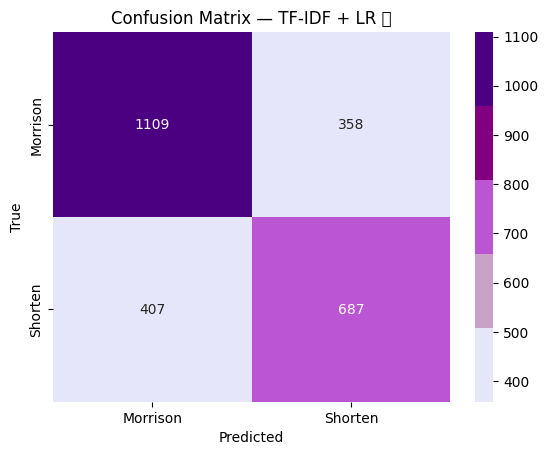

In [ ]:
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix # Import confusion_matrix

# Define the confusion matrix
cm = confusion_matrix(y_test, pred)

purple_cmap = ListedColormap(["#E6E6FA", "#C8A2C8", "#BA55D3", "#800080", "#4B0082"])

# Graphic confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap=purple_cmap,
            xticklabels=["Morrison", "Shorten"],
            yticklabels=["Morrison", "Shorten"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix — TF-IDF + LR 💜")
plt.show()

## Part 2: Feature Engineering with POS and NER

Import Spacy and load model

In [ ]:
import sys
import subprocess

# Install/update spaCy in the current interpreter
subprocess.check_call([sys.executable, "-m", "pip", "install", "-U", "spacy"])
import spacy

# Try to load the model; if it fails, download the model and load again
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    subprocess.check_call([sys.executable, "-m", "spacy", "download", "en_core_web_sm"])
    nlp = spacy.load("en_core_web_sm")

print("spaCy y modelo en_core_web_sm ready.")

spaCy y modelo en_core_web_sm listos.


In [ ]:
# Load the model in English "en_core_web_sm"
# This model constains linguistic rules, part-of-speech tags (POS tags), 
# named entities (people, places, organizations, etc.), and syntactic dependencies.
nlp = spacy.load("en_core_web_sm")


Preprocess texts to extract POS + NER

In [ ]:
# Define a function that extracts Part-of-Speech (POS) tags and Named Entity Recognition (NER) tags from a text
def extract_pos_ner(text):
    # Process the text with the previously loaded spaCy model (nlp)
    # This generates a "doc" object with linguistic information about the text
    doc = nlp(text)

    # Extract the Part-of-Speech tags
    # For example: NOUN, VERB, ADJ, etc.
    pos_tags = [token.pos_ for token in doc]

    # Extract the Named Entity Recognition tags
    # For example: PERSON, ORG, GPE, etc.
    ner_tags = [ent.label_ for ent in doc.ents]

    # Return both lists as a tuple
    return pos_tags, ner_tags

# Apply the function to each clean text in the DataFrame
# The function returns two lists for each text, so we use "zip(*...)" to separate them into two columns
df_final["pos_tags"], df_final["ner_tags"] = zip(
    *df_final["clean_text"].apply(extract_pos_ner)
)


Count POS / NER

In [ ]:
from collections import Counter 

# Create a set of all the Part-of-Speech (POS) tags present in the DataFrame
# Go throguh each row in the 'pos_tags' column and then each tag (pos) within that list

all_pos = set([pos for row in df_final["pos_tags"] for pos in row])

# Show all unique Part-of-Speech tags found in the texts
print(all_pos)


{'AUX', 'ADP', 'PUNCT', 'CCONJ', 'SYM', 'PRON', 'INTJ', 'DET', 'X', 'NUM', 'NOUN', 'ADV', 'PROPN', 'SCONJ', 'ADJ', 'PART', 'VERB'}


Crear columnas de conteo POS

In [ ]:
# We define a function that counts how many times each POS tag appears in a list
def pos_counts(tag_list):
    # Counter creates a dictionary where the keys are POS tags and the values are the times they appear
    counter = Counter(tag_list)
    return counter

# Apply the function to each row of the 'pos_tags' column (each row is a list of POS)
# Then each result is a dictionary, so we use .apply(pd.Series) to convert it into columns,
# where each type of tag (NOUN, VERB, etc.) will be a numeric column.
pos_features = df_final["pos_tags"].apply(pos_counts).apply(pd.Series).fillna(0)

pos_features.head()


,NOUN,VERB,DET,ADJ,ADP,SCONJ,ADV,PRON,AUX,PART,PROPN,CCONJ,INTJ,NUM,X,SYM,PUNCT
11,14.0,3.0,8.0,6.0,4.0,1.0,4.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
20,7.0,6.0,3.0,1.0,2.0,1.0,0.0,4.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
23,5.0,5.0,3.0,1.0,4.0,1.0,1.0,0.0,3.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
24,5.0,3.0,2.0,4.0,3.0,0.0,0.0,1.0,1.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0


Create the count NER columns

In [ ]:
# Define the function that counts how many times each Named Entity Recognition (NER) type appears
def ner_counts(tag_list):
    # Create a counter with the entity tags, for example:
    # ['PERSON', 'ORG', 'GPE'] → {'PERSON': 1, 'ORG': 1, 'GPE': 1}
    counter = Counter(tag_list)
    return counter 

# Apply the function to the 'ner_tags' column (which contains lists of NER tags)
# Each result is a dictionary, and then we convert it into columns with pd.Series
# Each type of entity (PERSON, ORG, GPE, etc.) will be a numeric column.
ner_features = df_final["ner_tags"].apply(ner_counts).apply(pd.Series).fillna(0)

ner_features.head()


,ORG,GPE,NORP,PERSON,ORDINAL,DATE,FAC,LOC,TIME,CARDINAL,MONEY,LANGUAGE,PRODUCT,EVENT,QUANTITY,WORK_OF_ART
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


POS + NER with TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create the vectorizer TF-IDF with certain parameters
tfidf = TfidfVectorizer(
    lowercase=True,    # Converts all the text to lowercase
    ngram_range=(1,2), # Considers unigrams and bigrams (single words and pairs of words)   
    max_features=30000 # Limits the number of features to 30,000
)

# Adjust the vectorizer to the entire text column and transform the texts into vectors
# This generates a sparse matrix where each row is a text and each column a term
X_text = tfidf.fit_transform(df_final["clean_text"])


In [ ]:
from scipy.sparse import hstack, csr_matrix

# Convert the features POS into a sparse matrix
# This is necessary because X_text (TF-IDF) is also sparse
X_pos = csr_matrix(pos_features.values)

# Convert the features NER into a sparse matrix
X_ner = csr_matrix(ner_features.values)

# Combine horizontally the three matrices (TF-IDF + POS + NER)
# hstack produces a new matrix where each row represents a text and the columns contain all features together
X_full = hstack([X_text, X_pos, X_ner])


### Train test split

In [ ]:
from sklearn.model_selection import train_test_split

# Divide the hybrid feature matrix and the labels into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_full,                 
    df_final["stance"],    
    test_size=0.2,          
    random_state=42,       
    stratify=df_final["stance"]  
)


### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

# Create the classifier
clf_pos_ner = LogisticRegression(
    max_iter=2000, 
    n_jobs=-1    
)

# Train the model with the hybrid features (text + POS + NER) and the labels
clf_pos_ner.fit(X_train, y_train)
# The model learns the word patterns and linguistic features to predict the stance

# Predict on the test set
pred = clf_pos_ner.predict(X_test)
# This returns an array with the predicted labels: 0 = Pro-Morrison, 1 = Pro-Shorten


In [ ]:
# Calculate the model accuracy
print("Accuracy:", accuracy_score(y_test, pred))
# Accuracy = percentage of correct predictions over the total examples
# Ideal to see overall how well the model performs

# Show a detailed classification report
print("\nClassification Report:\n")
print(classification_report(y_test, pred))
# This includes per class:
#  - Precision: of all those predicted as that class by the model, how many are correct.
#  - Recall: of all those who really are of that class, how many were correctly
#  - F1-score: average between precision and recall (balance between both).
#  - Support: quantity of true examples of each class.

Accuracy: 0.7012885591565795

Classification Report:

              precision    recall  f1-score   support

           0       0.73      0.76      0.74      1467
           1       0.66      0.63      0.64      1094

    accuracy                           0.70      2561
   macro avg       0.69      0.69      0.69      2561
weighted avg       0.70      0.70      0.70      2561



/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128156 (\N{PURPLE HEART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


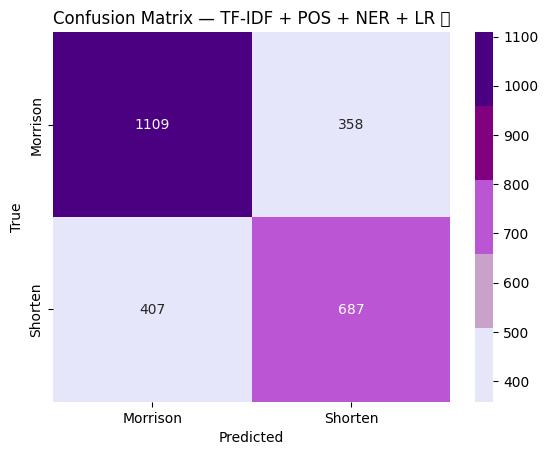

In [ ]:
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix

# Define the confusion matrix using the predictions from the latest model
cm = confusion_matrix(y_test, pred)

# Define a confusion matrix with a purple color palette
purple_cmap = ListedColormap(["#E6E6FA", "#C8A2C8", "#BA55D3", "#800080", "#4B0082"])

# Graphic confusion matrix
sns.heatmap(
    cm, annot=True, fmt="d", cmap=purple_cmap,
    xticklabels=["Morrison", "Shorten"],
    yticklabels=["Morrison", "Shorten"]
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix — TF-IDF + POS + NER + LR 💜")
plt.show()

## Part 3: Transformer based model

In [47]:
import torch
import datasets
from torch.utils.data import DataLoader
from datasets import Dataset

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)

In [ ]:
# Make a copy of the clean DataFrame to avoid modifying the original
df = df_clean.copy()

# Stay only with the necessary columns: 'clean_text' and 'stance' and remove rows with null values
df = df[["clean_text", "stance"]].dropna()

# Reduce the size of the dataset to train on CPU (faster)
# Randomly select 1,500 rows for training
df_train = df.sample(1500, random_state=42)

# Take 500 different rows for the test set
df_test  = df.drop(df_train.index).sample(500, random_state=42)

# Show the dimensions of the training and test sets
print(df_train.shape, df_test.shape)


(1500, 2) (500, 2)


In [54]:
train_ds = Dataset.from_pandas(df_train)
test_ds = Dataset.from_pandas(df_test)

### Tokens

In [ ]:
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

MAX_LEN = 128   # Reduced for CPU


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# Define a function to tokenize a batch of texts using the Hugging Face tokenizer
def tokenize(batch):
    return tokenizer(
        batch["clean_text"],   #  Column with texts
        truncation=True,       #  Cuts texts that exceed max_length
        padding="max_length",  #  Fills short texts to max_length
        max_length=MAX_LEN     #  Maximum length of tokens per text
    )

# Apply the tokenization function to the entire dataset (batched=True processes in batches)
train_ds_tok = train_ds.map(tokenize, batched=True)
test_ds_tok  = test_ds.map(tokenize, batched=True)

# Make sure the 'stance' column is of integer type before renaming it
train_ds_tok = train_ds_tok.cast_column("stance", datasets.Value("int64"))
test_ds_tok  = test_ds_tok.cast_column("stance", datasets.Value("int64"))

# Rename the column 'stance' to 'labels', which is what Hugging Face models expect
train_ds_tok = train_ds_tok.rename_column("stance", "labels")
test_ds_tok  = test_ds_tok.rename_column("stance", "labels")

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1500 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/500 [00:00<?, ? examples/s]

### Model

In [ ]:
# Load the pretrained model from the specified checkpoint
# num_labels=2 → because we have two classes: 0 (Pro-Morrison) and 1 (Pro-Shorten)
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    num_labels=2
)

# Configure the model for single-label classification
# 'single_label_classification' indicates that each example belongs to a single class
# This is important for the loss function (CrossEntropyLoss)
model.config.problem_type = "single_label_classification"

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Define a function that calculates metrics to evaluate the model
def compute_metrics(eval_pred):
    # eval_pred es una tupla: (logits, labels)
    logits, labels = eval_pred

    # Obtain the predictions by selecting the index with the maximum value
    # This converts the logits into the predicted class (0 or 1)
    preds = np.argmax(logits, axis=1)

    # Calculate the accuracy by comparing predictions vs real labels
    acc = accuracy_score(labels, preds)

    # Returnamos un diccionario con las métricas
    # Hugging Face Trainer expects a dictionary to display at each evaluation
    return {"accuracy": acc}



Arguments for the training

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",           #  Folder where chekpoints and results will be saved
    eval_strategy="epoch",            #  Evaluate the model at the end of each epoch
    save_strategy="no",               #  Don't save checkpoints during training
    learning_rate=2e-5,               #  Optimizer learning rate (LR)
    per_device_train_batch_size=16,   #  Batch size for training
    per_device_eval_batch_size=16,    #  Batch size for evaluation
    num_train_epochs=2,               #  Number of epochs to train
    weight_decay=0.01,                #  Regularization to avoid overfitting
    logging_steps=20,                 #  Every 20 steps, training metrics are logged
    report_to="none"                  #  Don't report to any external system (like WandB)
)



## Training

In [60]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds_tok,
    eval_dataset=test_ds_tok,
    compute_metrics=compute_metrics,
)

trainer.train()

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy
1,0.634400,0.623223,0.620000
2,0.559700,0.613158,0.644000


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=188, training_loss=0.6025869047388117, metrics={'train_runtime': 2298.8499, 'train_samples_per_second': 1.305, 'train_steps_per_second': 0.082, 'total_flos': 99350548992000.0, 'train_loss': 0.6025869047388117, 'epoch': 2.0})

## Predictions

In [ ]:
# Make predictions on the test dataset using the trainer
preds = trainer.predict(test_ds_tok)
# preds.predictions -> raw logits (model output before softmax)
#  preds.label_ids → real labels

# Convert the logits into predicted labels (0 or 1)
y_pred = np.argmax(preds.predictions, axis=1)
#  axis=1 → choose the class with the highest value for each example

# Save the real labels
y_true = preds.label_ids

# Calculate the model accuracy
print("Accuracy:", accuracy_score(y_true, y_pred))
#  Accuracy = proportion of correct predictions

# Show a detailed classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred))

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Accuracy: 0.644

Classification Report:

              precision    recall  f1-score   support

           0       0.66      0.69      0.67       267
           1       0.62      0.59      0.61       233

    accuracy                           0.64       500
   macro avg       0.64      0.64      0.64       500
weighted avg       0.64      0.64      0.64       500



## Part 4: Hybrid Models

#### **POS-tagged N-grams (Syntactic N-grams)**

In [ ]:
import spacy                      
nlp = spacy.load("en_core_web_sm")  # Load the small English model


### Function to convert text to a POS-tag sequence

In [ ]:
def get_pos_tags(text):
    # Analize the text with spaCy to obtain linguistic information
    doc = nlp(text)

    # Returns a list with the Part-of-Speech tags (POS tags) of each token
    # Example: ["DET", "NOUN", "VERB", "ADJ"]
    return [token.pos_ for token in doc]


### Function to extract POS n-grams

In [ ]:
def get_pos_ngrams(tags, n=2):
    # Create a list of n-grams (by default, bigrams) from the POS tags.
    # For example, if tags = ["DET", "NOUN", "VERB", "ADJ"]
    # it will return: ["DET_NOUN", "NOUN_VERB", "VERB_ADJ"]
    
    return ["_".join(tags[i:i+n]) for i in range(len(tags)-n+1)]
    # tags[i:i+n] → takes a window of n consecutive tags
    # "_".join(...) → puts those tags together with underscores
    # The loop goes through all possible positions in the tag list


### Wrapper

In [ ]:
def extract_pos_ngram_string(text, n=2):
    #  Obtain the POS tags from the text
    tags = get_pos_tags(text)

    # Generate n-grams from those tags
    ngrams = get_pos_ngrams(tags, n)
    # IF n=2 → ["DET_NOUN", "NOUN_AUX", "AUX_ADJ"]

    # Unite the n-grams into a single string, separated by spaces
    # This leaves it ready to be vectorized with TF-IDF
    return " ".join(ngrams)
    # Result: "DET_NOUN NOUN_AUX AUX_ADJ"


### Apply to the DataFrame

In [ ]:
# Apply the function to extract POS n-grams as strings to each row of the "clean_text" column
# The parameter n=2 indicates that you want grammatical bigrams (pairs of consecutive POS tags)
df_final["pos_ngrams"] = df_final["clean_text"].apply(lambda x: extract_pos_ngram_string(x, n=2))

df_final.head()


,created_at,id,full_text,retweet_count,favorite_count,user_id,user_name,user_screen_name,user_description,user_location,user_created_at,clean_text,stance,pos_tags,ner_tags,pos_ngrams
11,2019-05-20 09:11:19,1130400598279352320,Comment: Losing the unlosable election: the af...,0.0,0.0,3.045738e+09,Ice Maiden,virginsnowbunny,NaN,NaN,2015-02-27 07:21:25,comment losing the unlosable election the afte...,1,"[NOUN, VERB, DET, ADJ, NOUN, DET, NOUN, ADP, N...",[],NOUN_VERB VERB_DET DET_ADJ ADJ_NOUN NOUN_DET D...
18,2019-05-20 09:07:19,1130399591986155522,BBC News - 2019 Australia election: Morrison's...,0.0,0.0,1.118532e+18,markasher224,markasher224,"game,movie,beer,traking,brive",NaN,2019-04-17 15:10:39,bbc news australia election morrisons coalitio...,1,"[PROPN, PROPN, PROPN, NOUN, NOUN, NOUN, VERB, ...",[ORG],PROPN_PROPN PROPN_PROPN PROPN_NOUN NOUN_NOUN N...
20,2019-05-20 09:07:04,1130399529897844736,"Whatever mistakes Labor made, we know democrac...",25.0,56.0,2.675709e+08,Wayne Swan,SwannyQLD,Wayne Swan is the National President of the AL...,Brisbane,2011-03-17 04:55:00,whatever mistakes labor made we know democracy...,0,"[PRON, VERB, NOUN, VERB, PRON, VERB, NOUN, AUX...",[],PRON_VERB VERB_NOUN NOUN_VERB VERB_PRON PRON_V...
23,2019-05-20 09:06:18,1130399338692112389,Journalists need to get an ironclad guarantee ...,1.0,2.0,3.784206e+08,Sandra K Eckersley🔹,SandraEckersley,"Writer, Critic, Ideas Broker & Devil's Advocat...",Sydney AUSTRALIA,2011-09-23 05:17:47,journalists need to get an ironclad guarantee ...,1,"[NOUN, VERB, PART, VERB, DET, ADJ, NOUN, SCONJ...","[GPE, GPE]",NOUN_VERB VERB_PART PART_VERB VERB_DET DET_ADJ...
24,2019-05-20 09:05:39,1130399173877141504,Australian Voters Reject Leftist Ideas \n-http...,0.0,0.0,1.005636e+18,FullMagazine❌,FullMagazineUS,Pro-Trump News Aggregator. The latest headline...,"Texas, USA",2018-06-10 02:21:11,australian voters reject leftist ideas nationa...,0,"[ADJ, NOUN, VERB, ADJ, NOUN, PROPN, PROPN, ADJ...","[NORP, NORP, PERSON, ORG, GPE]",ADJ_NOUN NOUN_VERB VERB_ADJ ADJ_NOUN NOUN_PROP...


In [ ]:
# Deletes rows where the 'pos_ngrams' column has null (NaN) values
# This avoids errors later in the vectorizer or model
df_final = df_final.dropna(subset=["pos_ngrams"])

# Resets the index of the DataFrame after removing rows
# drop=True avoids adding the previous index as a column
df_final = df_final.reset_index(drop=True)


### Train test split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_final["pos_ngrams"],   #  Features (input): sequences of grammatical bigrams
    df_final["stance"],       #  Labels: 0 = Pro-Morrison, 1 = Pro-Shorten
    test_size=0.2,            #  20% of the data will be reserved for testing
    random_state=42,          #  Sets a seed for reproducibility
    stratify=df_final["stance"]  #  Maintains the class proportion equal in both sets
)


### Vectorizer (TF-IDF over POS-ngrams)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_pos = TfidfVectorizer(
    ngram_range=(1,2),   # <-- Generates unigrams and bigrams from the POS n-grams.
                         #     For pairs of POS tags, this means single tags (DET, NOUN, VERB)
                         #     and consecutive pairs (DET_NOUN NOUN_VERB).
    min_df=2             # <-- Ignores terms that appear in less than 2 documents.
                         #     Reduces noise from very rare grammatical patterns.
)


### Logistic Regression Classifier

In [ ]:
from sklearn.linear_model import LogisticRegression

clf_pos = LogisticRegression(max_iter=2000)
# Create an instance of the Logistic Regression classifier.
# Parameter:
# - max_iter=2000: sets the maximum number of iterations that the optimizer
#   can use to converge (default is 100, but when working with TF-IDF
#   and many features, it may need more).
# This model will be trained later with the vectorized data (TF-IDF).


### Create the pipeline

In [ ]:
from sklearn.pipeline import Pipeline

pipe_pos = Pipeline([
    ("tfidf", tfidf_pos),
    # First step of the pipeline:
    # Applies the TF-IDF vectorizer (tfidf_pos) to the texts.
    # This converts the text into a numerical matrix that represents the importance of each word or bigram.
    
    ("clf", clf_pos)])
    # Second step of the pipeline:
    # Uses the Logistic Regression model (clf_pos) to train with the features generated by TF-IDF.

# Together, these two steps form a complete pipeline for text classification.


### Training

In [ ]:
pipe_pos.fit(X_train, y_train)

# Internally, the pipeline does the following:
#  It takes the texts in X_train and passes them to the first step of the pipeline ("tfidf").
#     → The TF-IDF vectorizer converts the 'pos_ngrams' texts into a numerical matrix.
#  That numerical matrix is passed to the second step ("clf"), i.e., Logistic Regression.
#     → The model learns the relationships between the TF-IDF values and the 'stance' labels (Morrison or Shorten).
#  After training, the pipeline is ready to predict on new texts.


Pipeline(steps=[('tfidf', TfidfVectorizer(min_df=2, ngram_range=(1, 2))),
                ('clf', LogisticRegression(max_iter=2000))])

### Predictions and evaluation

In [ ]:
# Make predictions on the test set
# pipe_pos automatically applies TF-IDF to X_test and then Logistic Regression
y_pred = pipe_pos.predict(X_test)

# Calculate and print the evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))

# Show a detailed classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Show a confusion matrix
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.5974228816868411

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.72      0.67      1467
           1       0.54      0.43      0.48      1094

    accuracy                           0.60      2561
   macro avg       0.58      0.58      0.58      2561
weighted avg       0.59      0.60      0.59      2561


Confusion Matrix:
 [[1056  411]
 [ 620  474]]


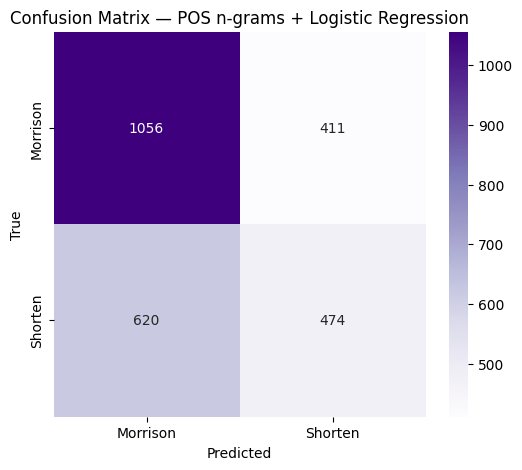

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

#  Graphical representation of the confusion matrix with seaborn
plt.figure(figsize=(6,5))
sns.heatmap(
    cm,                   
    annot=True,           
    fmt="d",             
    cmap="Purples",       
    xticklabels=["Morrison", "Shorten"], 
    yticklabels=["Morrison", "Shorten"]  
)

plt.xlabel("Predicted")   
plt.ylabel("True")       
plt.title("Confusion Matrix — POS n-grams + Logistic Regression") 

plt.show()


### **NER-tag-enhanced n-grams**

Replace entities with NER label

In [ ]:
def text_to_ner_tokens(text):
    # Analize the text with spaCy to obtain linguistic information
    doc = nlp(text)

    # List to store the modified tokens
    tokens = []

    # Go through each token in the analyzed document
    for token in doc:
        if token.ent_type_ != "":
            # If the token is part of a named entity, we store the entity type instead of the token
            tokens.append(token.ent_type_)
        else:
            # If it is not an entity, we store the token as is
            tokens.append(token.text)

    return tokens


In [ ]:
def get_ngrams(tokens, n=2):
    # Create a list of n-grams from the list of tokens
    # For example, if tokens = ["PERSON", "visited", "GPE"]
    # and n=2, it will return: ["PERSON_visited", "visited_GPE"]

    return ["_".join(tokens[i:i+n]) for i in range(len(tokens) - n + 1)]
    #  tokens[i:i+n] → takes a window of n consecutive tokens
    #  "_".join(...) → unites those tokens with underscores
    #  Goes through all possible positions in the token list

### Apply it to each post

In [ ]:
from tqdm import tqdm

# Empty list to store the NER n-grams for each text
ner_ngrams_list = []

for text in tqdm(df_final["clean_text"]):
    # Go through each clean text in the DataFrame, showing progress
    tokens = text_to_ner_tokens(text)
    # Convert the text into NER tokens: normal words + entity types
    # Example: "Scott Morrison visited Australia" → ["PERSON", "visited", "GPE"]

    ngrams = get_ngrams(tokens, n=2)
    # Generate n-grams (consecutive pairs) from the tokens
    # Example: ["PERSON_visited", "visited_GPE"]

    ner_ngrams_list.append(" ".join(ngrams))
    # Convert the list of n-grams into a single string separated by spaces and add it to the final list

# Create a new column in the DataFrame with the NER n-grams
df_final["ner_ngrams"] = ner_ngrams_list

df_final.head()


100%|██████████| 12805/12805 [02:13<00:00, 96.21it/s]


,created_at,id,full_text,retweet_count,favorite_count,user_id,user_name,user_screen_name,user_description,user_location,user_created_at,clean_text,stance,pos_tags,ner_tags,pos_ngrams,ner_ngrams
0,2019-05-20 09:11:19,1130400598279352320,Comment: Losing the unlosable election: the af...,0.0,0.0,3.045738e+09,Ice Maiden,virginsnowbunny,NaN,NaN,2015-02-27 07:21:25,comment losing the unlosable election the afte...,1,"[NOUN, VERB, DET, ADJ, NOUN, DET, NOUN, ADP, N...",[],NOUN_VERB VERB_DET DET_ADJ ADJ_NOUN NOUN_DET D...,comment_losing losing_the the_unlosable unlosa...
1,2019-05-20 09:07:19,1130399591986155522,BBC News - 2019 Australia election: Morrison's...,0.0,0.0,1.118532e+18,markasher224,markasher224,"game,movie,beer,traking,brive",NaN,2019-04-17 15:10:39,bbc news australia election morrisons coalitio...,1,"[PROPN, PROPN, PROPN, NOUN, NOUN, NOUN, VERB, ...",[ORG],PROPN_PROPN PROPN_PROPN PROPN_NOUN NOUN_NOUN N...,ORG_ORG ORG_ORG ORG_election election_morrison...
2,2019-05-20 09:07:04,1130399529897844736,"Whatever mistakes Labor made, we know democrac...",25.0,56.0,2.675709e+08,Wayne Swan,SwannyQLD,Wayne Swan is the National President of the AL...,Brisbane,2011-03-17 04:55:00,whatever mistakes labor made we know democracy...,0,"[PRON, VERB, NOUN, VERB, PRON, VERB, NOUN, AUX...",[],PRON_VERB VERB_NOUN NOUN_VERB VERB_PRON PRON_V...,whatever_mistakes mistakes_labor labor_made ma...
3,2019-05-20 09:06:18,1130399338692112389,Journalists need to get an ironclad guarantee ...,1.0,2.0,3.784206e+08,Sandra K Eckersley🔹,SandraEckersley,"Writer, Critic, Ideas Broker & Devil's Advocat...",Sydney AUSTRALIA,2011-09-23 05:17:47,journalists need to get an ironclad guarantee ...,1,"[NOUN, VERB, PART, VERB, DET, ADJ, NOUN, SCONJ...","[GPE, GPE]",NOUN_VERB VERB_PART PART_VERB VERB_DET DET_ADJ...,journalists_need need_to to_get get_an an_iron...
4,2019-05-20 09:05:39,1130399173877141504,Australian Voters Reject Leftist Ideas \n-http...,0.0,0.0,1.005636e+18,FullMagazine❌,FullMagazineUS,Pro-Trump News Aggregator. The latest headline...,"Texas, USA",2018-06-10 02:21:11,australian voters reject leftist ideas nationa...,0,"[ADJ, NOUN, VERB, ADJ, NOUN, PROPN, PROPN, ADJ...","[NORP, NORP, PERSON, ORG, GPE]",ADJ_NOUN NOUN_VERB VERB_ADJ ADJ_NOUN NOUN_PROP...,NORP_voters voters_reject reject_leftist lefti...


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_final["ner_ngrams"],   #  Features (input): sequences of NER n-grams
    df_final["stance"],       #  Labels: 0 = Pro-Morrison, 1 = Pro-Shorten
    test_size=0.2,            #  20% of the data will be reserved for testing
    random_state=42,          #  Set a seed for reproducibility
    stratify=df_final["stance"]  # Maintains the class proportion equal in both sets
)


### TF-IDF Vectorizer

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create the TF-IDF vectorizer with specific parameters for NER n-grams
tfidf_ner = TfidfVectorizer(
    ngram_range=(1,2),   # <-- Takes unigrams and bigrams from the NER n-grams.
                         #     For example:    "PERSON_visited"   
    min_df=2             # <-- Ignores terms that appear in less than 2 documents.
                          #    Reduces noise from very rare patterns.
)


## Logistic Regression

In [82]:
clf_ner = LogisticRegression(max_iter=2000)

### Training

In [ ]:
from sklearn.pipeline import Pipeline

# Creatate a pipeline for NER n-grams classification
pipe_ner = Pipeline([
    ("tfidf", tfidf_ner),  # Step 1: TF-IDF vectorizer
                            # Converts NER n-grams into a numerical matrix
    ("clf", clf_ner),      # Step 2: Logistic Regression classifier
                            # Learns to predict the stance based on the features
])

#  Train the NER n-grams pipeline with the training data
pipe_ner.fit(X_train, y_train)


Pipeline(steps=[('tfidf', TfidfVectorizer(min_df=2, ngram_range=(1, 2))),
                ('clf', LogisticRegression(max_iter=2000))])

### Prediction and evaluation

In [ ]:
# Make predictions on the test set
y_pred = pipe_ner.predict(X_test)

# Calculate model accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Show a detailed classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Print the confusion matrix
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.6864506052323311

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.78      0.74      1467
           1       0.65      0.57      0.61      1094

    accuracy                           0.69      2561
   macro avg       0.68      0.67      0.67      2561
weighted avg       0.68      0.69      0.68      2561


Confusion Matrix:
 [[1137  330]
 [ 473  621]]


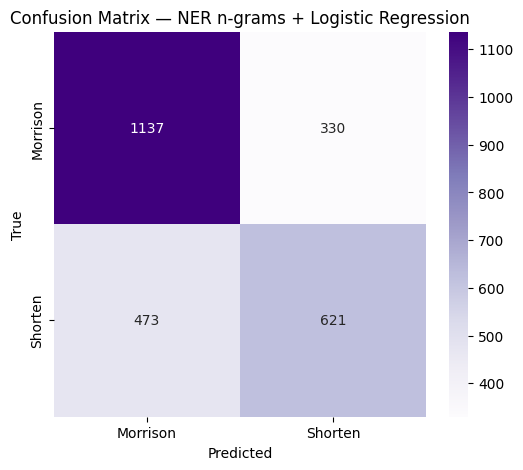

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Graphical representation of the confusion matrix with seaborn
plt.figure(figsize=(6,5)) 
sns.heatmap(
    cm,                  
    annot=True,          
    fmt="d",              
    cmap="Purples",     
    xticklabels=["Morrison", "Shorten"], 
    yticklabels=["Morrison", "Shorten"])

plt.xlabel("Predicted")  
plt.ylabel("True")      
plt.title("Confusion Matrix — NER n-grams + Logistic Regression")

plt.show()


### **Mixed Embeddings + Attention**

### Generate POS / NER tags

In [ ]:
def pos_ner_tags(text):
    # Analize the text and extract POS tags and NER tags
    doc = nlp(text)

    pos = [token.pos_ for token in doc]
    ner = [token.ent_type_ if token.ent_type_ != "" else "O" for token in doc]
    
    return pos, ner

# Apply the function to the 'clean_text' column to extract POS and NER tags
df_final["pos"], df_final["ner"] = zip(*df_final["clean_text"].apply(pos_ner_tags))
# - df_final["pos"] → list of POS tags per text
# - df_final["ner"] → list of NER tags per text


In [ ]:
from itertools import chain

# ------------------- POS -------------------
pos_vocab = {"PAD":0}
# Create a dictionary for the POS vocabulary
# "PAD" stans for padding if the sequences hace a different longitud and will always have index 0

for p in set(chain(*df_final["pos"])):
    # chain(*) is used to flatten the lists of POS tags from each row
    # set(...) obtains unique POS tags
    if p not in pos_vocab:
        pos_vocab[p] = len(pos_vocab)
        # Assigns a unique index to each POS tag

# ------------------- NER -------------------
ner_vocab = {"PAD":0}
# Dictionary for NER vocabulary
for n in set(chain(*df_final["ner"])):
    if n not in ner_vocab:
        ner_vocab[n] = len(ner_vocab)
        # Assings a unique index to each NER tag

# Size of each vocabulary
print("POS vocab size:", len(pos_vocab))
print("NER vocab size:", len(ner_vocab))


POS vocab size: 18
NER vocab size: 18


In [ ]:
MAX_LEN = 128
# Maximun sequence length
# If the sequence is longer it will be filled with padding

def encode_sequence(seq, vocab, max_len=MAX_LEN):
    # Converts a list of labels (POS or NER) to numerical indexs.
    ids = [vocab[t] for t in seq[:max_len]]
    # Goes through the sequence until max_len and replaces each label for an index in vocab
    if len(ids) < max_len:
        ids += [0] * (max_len - len(ids))
    return ids

# Apply the function to the entire "pos" column of the DataFrame
df_final["pos_ids"] = df_final["pos"].apply(lambda x: encode_sequence(x, pos_vocab))

# Apply the function to the entire "ner" column of the DataFrame
df_final["ner_ids"] = df_final["ner"].apply(lambda x: encode_sequence(x, ner_vocab))

# Show the first 5 rows of the new columns with the numerical sequences
print(df_final[["pos_ids","ner_ids"]].head())


                                             pos_ids  \
0  [11, 17, 8, 15, 11, 8, 11, 2, 11, 14, 15, 11, ...   
1  [13, 13, 13, 11, 11, 11, 17, 11, 11, 0, 0, 0, ...   
2  [6, 17, 11, 17, 6, 17, 11, 1, 2, 11, 14, 8, 11...   
3  [11, 17, 16, 17, 8, 15, 11, 14, 13, 1, 16, 1, ...   
4  [15, 11, 17, 15, 11, 13, 13, 15, 13, 13, 13, 1...   

                                             ner_ids  
0  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...  
1  [1, 1, 1, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, ...  
2  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...  
3  [3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, ...  
4  [16, 3, 3, 3, 3, 3, 3, 16, 3, 3, 17, 17, 3, 3,...  


In [ ]:
# Rename columns for compatibility with Hugging Face models
df_final = df_final.rename(columns={"stance": "labels"})

# Delete where labels is null
df_final = df_final.dropna(subset=["labels"])

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

# Create the labels in numbers
# For example, "Pro-Morrison" → 0, "Pro-Shorten" → 1
df_final["labels"] = le.fit_transform(df_final["labels"])

In [90]:
df_final = df_final.rename(columns={'stance': 'labels'})

### Train test split

In [ ]:
train_df, test_df = train_test_split(
    df_final,                  # Complete dataframe
    test_size=0.2,             # 20% of the data are reserved for testing
    random_state=42,           # Set a seed for reproducibility
    stratify=df_final["labels"] # Maintain class proportions in both sets
)

### Convert to HuggingFace dataset

In [ ]:
from datasets import Dataset

# Convert the DataFrame of training into a Dataset
train_ds = Dataset.from_pandas(train_df)

# Convert the DataFrame of training into a Dataset
test_ds  = Dataset.from_pandas(test_df)


#### Tokenize

In [ ]:
from transformers import AutoTokenizer

MODEL_NAME = "distilbert-base-uncased"
# Name of the pretrained Hugging Face model we are going to use

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
# Load the tokenizer corresponding to DistilBERT

MAX_LEN = 64

def tokenize(batch):
    # Function to tokenize a batch of texts
    enc = tokenizer(
        batch["clean_text"],  
        truncation=True,       
        padding="max_length",  
        max_length=MAX_LEN    
    )
    return enc

# Apply the tokenization to the entire training dataset
train_ds_tok = train_ds.map(tokenize, batched=True)

# Apply the tokenization to the entire test dataset
test_ds_tok  = test_ds.map(tokenize, batched=True)


Map:   0%|          | 0/10244 [00:00<?, ? examples/s]

Map:   0%|          | 0/2561 [00:00<?, ? examples/s]

In [ ]:
# Training dataset
def add_pos_ner(example, idx):
    # Add the Ids of POS and NER to each example
    example["pos_ids"] = train_df.iloc[idx]["pos_ids"]  # POS sequence
    example["ner_ids"] = train_df.iloc[idx]["ner_ids"]  # NER sequence
    return example

# Apply the function to the entire tokenized training dataset
train_ds_tok = train_ds_tok.map(add_pos_ner, with_indices=True)
# with_indices=True allows access to the original DataFrame index
# to assign the correct pos_ids and ner_ids to each example

# Test dataset
def add_pos_ner_test(example, idx):
    example["pos_ids"] = test_df.iloc[idx]["pos_ids"]
    example["ner_ids"] = test_df.iloc[idx]["ner_ids"]
    return example

# Apply the function to the entire tokenized test dataset
test_ds_tok = test_ds_tok.map(add_pos_ner_test, with_indices=True)


Map:   0%|          | 0/10244 [00:00<?, ? examples/s]

Map:   0%|          | 0/2561 [00:00<?, ? examples/s]

In [ ]:
# Training dataset
train_ds_tok.set_format(
    type="torch",  # Convert the data to PyTorch tensors
    columns=["input_ids", "attention_mask", "pos_ids", "ner_ids", "labels"])
    # Specify which columns we want as tensors
    # - input_ids: text tokens
    # - attention_mask: text attention mask    
    # - pos_ids: encoded POS sequence
    # - ner_ids: encoded NER sequence
    # - labels: classification labels

# Test dataset
test_ds_tok.set_format(
    type="torch",  # Convert the data to PyTorch tensors
    columns=["input_ids", "attention_mask", "pos_ids", "ner_ids", "labels"]
)


In [ ]:
import torch.nn as nn
from transformers import AutoModel

class MixedEncoder(nn.Module):
    def __init__(self, model_name, n_pos, n_ner, emb_dim=32, num_labels=2):
        super().__init__()

        # Load the pretrained transformer model (DistilBERT)
        self.encoder = AutoModel.from_pretrained(model_name)

        # Embedding layers to convert POS and NER indices into dense vectors
        self.pos_emb = nn.Embedding(n_pos, emb_dim)  # POS tags
        self.ner_emb = nn.Embedding(n_ner, emb_dim)  # NER tags

        hidden_size = self.encoder.config.hidden_size  # Size of the transformer output embeddings

        # Linear layer to combine CLS + POS + NER embeddings
        self.proj = nn.Linear(hidden_size + 2 * emb_dim, 128)
        self.classifier = nn.Linear(128, num_labels)  # end classification layer

        # Other layers for activation and regularization
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        pos_ids=None,
        ner_ids=None,
        labels=None,
    ):

        # Pass the text through the transformer
        outputs = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )

        cls_embed = outputs.last_hidden_state[:, 0]  # CLS token als global representation

        # Obtain the POS embeddings and average over the sequence
        pos_embed = self.pos_emb(pos_ids)
        pos_embed = pos_embed.mean(dim=1)

        # Obtain the NER embeddings and average over the sequence
        ner_embed = self.ner_emb(ner_ids)
        ner_embed = ner_embed.mean(dim=1)
        
        # Concatenate along dimension 1 (feature dimension)
        full = torch.cat([cls_embed, pos_embed, ner_embed], dim=1)
        x = self.proj(full)    # Linear projection
        x = self.relu(x)       # ReLU
        x = self.dropout(x)    # Dropout
        logits = self.classifier(x)  # Final classification layer


        # Calculate loss if labels are provided
        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)

        # Return a dictionary with loss and logits
        return {"loss": loss, "logits": logits}


In [ ]:
MODEL_NAME = "distilbert-base-uncased"
# Name of the pretrained transformer model we will use

EMB_DIM = 32
# Dimension of the embeddings for POS and NER

# Create the MixedEncoder model instance
model = MixedEncoder(
    MODEL_NAME,          # Ttransformer based model
    n_pos=len(pos_vocab), # Number of POS tags (size of the POS vocabulary)
    n_ner=len(ner_vocab), # Number of NER tags (size of the NER vocabulary)
    emb_dim=EMB_DIM,      # Dimension of the POS and NER embeddings
    num_labels=2)         # Number of classification labels (2 classes)


In [ ]:
from transformers import TrainingArguments, Trainer

# Training arguments for the Hugging Face Trainer
training_args = TrainingArguments(
    output_dir="./mixed_model",      # Folder where checkpoints and results will be saved
    eval_strategy="epoch",           # Evaluate the model at the end of each epoch
    save_strategy="epoch",           # Save a checkpoint at the end of each epoch
    per_device_train_batch_size=8,   # Batch size for training
    per_device_eval_batch_size=8,    # Batch size for evaluation
    num_train_epochs=1,              # Number of epochs to train
    learning_rate=3e-5,              # Optimizer learning rate
    weight_decay=0.01,               # L2 regularization to avoid overfitting
    remove_unused_columns=False,     # Don't remove unused columns (we need pos_ids and ner_ids)
)

# Metric computation function
def compute_metrics(pred):
    from sklearn.metrics import accuracy_score, f1_score
    labels = pred.label_ids                 # True labels
    preds = pred.predictions.argmax(-1)     # Model predictions
    return {
        "accuracy": accuracy_score(labels, preds),       # Accuracy
        "f1": f1_score(labels, preds, average="macro")  # F1-score macro
    }

# Trainer instance
trainer = Trainer(
    model=model,                  # MixedEncoder model
    args=training_args,           # Training arguments
    train_dataset=train_ds_tok,   # Training dataset
    eval_dataset=test_ds_tok,     # Evaluation dataset  
    compute_metrics=compute_metrics) # Function to compute metrics


In [ ]:
training_args = TrainingArguments(
    output_dir="./mixed_model",
    report_to="none",  # This disables logging to external services
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    learning_rate=3e-5,
    weight_decay=0.01,
    remove_unused_columns=False,
)


In [103]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds_tok,
    eval_dataset=test_ds_tok,
    compute_metrics=compute_metrics,
)

trainer.train()

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.459900,0.406961,0.811011,0.805182


TrainOutput(global_step=1281, training_loss=0.46654202582592336, metrics={'train_runtime': 3780.4272, 'train_samples_per_second': 2.71, 'train_steps_per_second': 0.339, 'total_flos': 0.0, 'train_loss': 0.46654202582592336, 'epoch': 1.0})

In [104]:
results = trainer.evaluate()
results

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.40696093440055847,
 'eval_accuracy': 0.811011323701679,
 'eval_f1': 0.8051820110171015,
 'eval_runtime': 240.4626,
 'eval_samples_per_second': 10.65,
 'eval_steps_per_second': 1.335,
 'epoch': 1.0}

# Conclusions:

After comparing the prior models and observing the metric and confussion matrixs we can see that the best model was the last one with an accuracy of 81%. We also believe the other models could have a better performance if we had more computational power, but since we don't they don't give results as good.